In [1]:
import sys
sys.path.append('..')

# Classification trees

## Intro

Classification trees are one type of **decision tree** that can be used for predicting categorical outputs.
In the next notebook we will look at regression trees, which are used for making continuous predictions.

If you have ever played the game 21 questions then you already know what a classification tree is.
Or if you've ever tried to code up an artificial general intelligence using a lot of `if` statements, then you've essentially built up your own decision tree by hand.

These examples use the obvious approach of building a classifier by asking a series of yes/no questions.
The answer to each question gives you more info on class of the object until the range of possible options becomes fine enough for you to settle on a prediction.

Below is an example of such a classifier.
This one predicts the gender using the height and weight of an example person.

![](images/CARTS_example_tree.png)

The above examples however, depend on you finding the right questions to ask manually.
We'd like to be able to find the right questions to ask automatically, using machine learning.
This means that we need to start quantifying what makes a **good** split.

![](images/CARTS_geni_impurity.png)

![](images/CARTS_split_pos.png)

## Maximum depth
One hyperparameter is the max depth that we will let our tree get

Once we have fit our tree to our data, it will make classifications by evaluating which leaf of the tree a given input arrives at and classifiying it as a member of the mode (most common) class of all the other points in the dataset which are also at that leaf.

Let's build a classification tree from scratch. The first cell below just sets up some helper functions that we used previously.

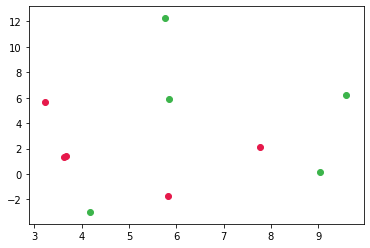

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import sklearn.datasets
from get_colors import colors
from utils import get_classification_data, show_data, visualise_predictions

# def get_data(sd=6, m=100, n_features=2, n_clusters=2):
#     X, Y = sklearn.datasets.make_blobs(n_samples=m, n_features=n_features, centers=n_clusters, cluster_std=sd)
#     return X, Y

# def show_data(X, Y, predictions=None):
#     for i in range(min(Y), max(Y)+1):
#         y = Y == i
#         x = X[y]
#         plt.scatter(x[:, 0], x[:, 1], c=colors[i])
#         if predictions is not None:
#             y = predictions == i
#             x = X[y]
#             plt.scatter(x[:, 0], x[:, 1], c=colors[i], marker='x', s=100)
#     fig = plt.gcf()
#     fig.set_size_inches(11,8)
#     plt.show()

# def visualise_predictions(H, X, n=50):
#     xmin, xmax, ymin, ymax = min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1])
#     meshgrid = np.zeros((n, n))
#     for x1_idx, x1 in enumerate(np.linspace(xmin, xmax, n)): # for each column
#         for x2_idx, x2 in enumerate(np.linspace(ymin, ymax, n)): # for each row
#             h = H(np.array([[x1, x2]])).astype(int)[0]
#             # plt.scatter(x1, x2, c=colors[h])
#             # print(h)
#             meshgrid[n-1-x2_idx, x1_idx] = h # axis 0 is the vertical direction starting from the top and increasing downward
#         # print()

#     # meshgrid[n-1, 0] = 1000
#     plt.imshow(meshgrid, extent=(xmin, xmax, ymin, ymax), cmap='viridis')

m = 60
n_features = 2
n_classes = 2
# X, Y = get_data(5, m, n_features, n_classes)
X, Y = get_classification_data()
show_data(X, Y)

{
    "split_impurity": 0.04938271604938271,
    "feature_to_split_on": 1,
    "value_to_split_on": -2.368223578994136,
    "positive_branch": {
        "split_impurity": 0.04938271604938271,
        "feature_to_split_on": 0,
        "value_to_split_on": 4.753129072402443,
        "positive_branch": {
            "split_impurity": 0.07999999999999999,
            "feature_to_split_on": 0,
            "value_to_split_on": 5.800904857700427,
            "positive_branch": {
                "split_impurity": 0.13333333333333333,
                "feature_to_split_on": 0,
                "value_to_split_on": 8.681539205957437,
                "positive_branch": {
                    "split_impurity": 0.0,
                    "feature_to_split_on": 0,
                    "value_to_split_on": 9.309161268343598,
                    "positive_branch": {
                        "split_impurity": 0,
                        "classification": 1.0
                    },
                    "negative

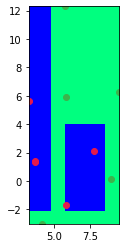

In [3]:
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
import json
import copy

class ClassificationTree:
    def __init__(self, max_depth=4):
        self.max_depth = max_depth

    def get_region_impurity(self, examples_in_region):
        """Get the impurity of a region"""
        x, Y = examples_in_region # unpack features and labels
        n_classes = np.ptp(Y) # get number of label classes from range of integer labels 
        n_datapoints = len(x) # get number of datapoints
        impurity = 0 # initialise zero impurity for this region
        for class_idx in range(n_classes): # for each class
            n_examples_in_class = len(x[Y == class_idx]) # get how many examples are in this class
            p_k = n_examples_in_class / n_datapoints # compute the proportion of examples in this region in class k
            impurity += p_k * (1 - p_k) # compute impurity from proportion
        return impurity # return impurity

    def get_split_impurity(self, x, Y, split_pos):
        """Get the impurity of a split, by making a weighted combination of it's resulting region impuritites"""
        in_first_region = (x[x > split_pos], Y[x > split_pos]) # get number of examples in first region
        proportion_in_first_region = len(in_first_region) / len(x) # calculate proportion of examples in first region
        not_in_first_region = (x[x <= split_pos], Y[x <= split_pos]) # get number of examples in the other region
        proportion_not_in_first_region = 1 - proportion_in_first_region # calculate proportion of examples in other region
        impurity = 0 # initialise impurity of split as zero
        impurity += proportion_in_first_region * self.get_region_impurity(in_first_region) # add the impurity of the first region, weighted by the proportion of examples that this split separates which end up in that region
        impurity += proportion_not_in_first_region * self.get_region_impurity(not_in_first_region) # add the impurity of the other region, weighted by the proportion of examples that this split separates which end up in that region
        return impurity # return total impurity

    def get_split_candidates(self, x):
        """Take in an array of a particular feature for each example, and return an array of feature values to consider splitting the data at, along this feature axis"""
        return (x[:-1] + x[1:]) / 2

    def get_best_split(self, X, Y):
        """Take in the features and labels of all of the datapoints in consideration. Compute best value and feature dimension to split the data on. Return the best feature value and feature index, and the impurity of the split""" 
        best_feature_to_split_on = None # initialise best feature to split on as none
        best_impurity = float('inf') # initialise best impurity found as infinity
        best_split_pos = None # initialise best value to split the data on as none
        for feature_idx in range(n_features): # for each feature
            x = X[:, feature_idx] # get this feature from each example
            split_pos, split_impurity = self.get_best_split_on_this_feature(x, Y) # get best split postition along this feature axis
            # print('feature impurity:', split_impurity)
            if split_impurity < best_impurity: # if this split impurity is the best so far
                best_split_pos = split_pos # update the best split position to this one
                best_impurity = split_impurity # update the best split impurity to this one
                best_feature_to_split_on = feature_idx # update the best split feature to this one
        # print('best_split_impurity:', best_impurity)
        return best_split_pos, best_impurity, best_feature_to_split_on # return best split position, impurity and feature idx

    def get_best_split_on_this_feature(self, x, Y):
        """
        Take in an array of a particular feature for each example and an array of their labels.
        Return the best value to split the data along this feature
        """
        split_candidates = self.get_split_candidates(x) # get candidate feature values to split the data on
        best_impurity = float('inf') # initialise the best impurity as infinity
        best_split_pos = None # initialise the best position to split on as none
        for split_pos in split_candidates: # for each candidate split position
            impurity = self.get_split_impurity(x, Y, split_pos) # get the split impurity
            if impurity < best_impurity: # if this is the best impurity so far
                best_impurity = impurity # update the best impurity to this one
                best_split_pos = split_pos # update the best split position to this one
        return best_split_pos, best_impurity # return best split position and best impurity

    def extend_tree(self, X, Y, depth=0):
        """
        Recursively grow the tree
        """
        split_val, split_impurity, split_feature = self.get_best_split(X, Y) # get the best split position
        if split_val == None: # split val will not exist (None) if there is only one datapoint in the split
            new_branch = {
                'split_impurity': 0, # so the split is pure
                'classification': np.mean(Y)
            }
            return new_branch
        
        positive_idxs = X[:, split_feature] > split_val # get idxs of datapoints that are split into the first region
        positive_X = X[positive_idxs] # get their features 
        positive_Y = Y[positive_idxs] # get their labels
        negative_idxs = np.logical_not(positive_idxs) # get idxs of datapoints that are split into the other region
        negative_X = X[negative_idxs] # get their features
        negative_Y = Y[negative_idxs] # get their labels
        new_branch = { # branch to be added to tree
            'split_impurity': split_impurity, # the split impurity of this branch
        }

        if depth < self.max_depth: # if not yet at max depth
            new_branch.update({ # add other attributes to the branch
                'feature_to_split_on': split_feature,
                'value_to_split_on': split_val,
                'positive_branch': self.extend_tree(positive_X, positive_Y, depth=depth+1), # recursion call 
                'negative_branch': self.extend_tree(negative_X, negative_Y, depth=depth+1) # reursion call
            })
        else: # if at max depth, stop growing the tree
            new_branch.update({'classification': np.mean(Y)}) # and just classify examples here as the mean
        return new_branch

    def fit(self, X, Y):
        """Grows the tree"""
        self.tree = self.extend_tree(X, Y) # recursive function to grow the tree

    def predict(self, X):
        """Makes predictions using the fitted tree"""
        classifications = np.zeros(len(X)) # initialise empty list of predictions
        for idx, x in enumerate(X): # enumerate over each example
            classified = False # indicator of whether it has been classified yet (initially false)
            tree = self.tree # save us having to repeat our self (lol)

            while classified == False: # while not yet classified
                if 'classification' in tree.keys(): # if the example can be classified from this branch (we have reached a leaf)
                    classified = True # mark as classified
                    classifications[idx] = tree['classification'] # get classification from this leaf of the tree
                else: # if we need to ask further questions about the example to make splits
                    if x[tree['feature_to_split_on']] > tree['value_to_split_on']: # is the example in the positive branch
                        tree = tree['positive_branch'] # move down this branch of the tree and continue the loop
                    else: # if the example is in the negative branch of the tree
                        tree = tree['negative_branch'] # move down this branch of the tree and continue the loop

        return classifications # return list of classifications

    def __repr__(self):
        """Returns a string representation of the tree"""
        return json.dumps(self.tree, indent=4) # convert the json representating the tree into a string with a nice indentation for readability

classificationTree = ClassificationTree(max_depth=5)
classificationTree.fit(X, Y)
visualise_predictions(classificationTree.predict, X, Y)
print(classificationTree)


Now let's use sklearn to implement the same thing 

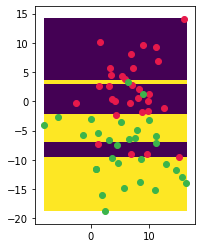

In [7]:
import sklearn.tree

classificationTree = sklearn.tree.DecisionTreeClassifier(max_depth=4)

classificationTree.fit(X, Y)
classificationTree.predict(X)
visualise_predictions(classificationTree.predict, X)
show_data(X, Y)


## sklearn hyperparameters

[Here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) is the full documentation for the sklearn classification tree.

## Classification tree limitations
- very prone to overfitting - no generalisation between similar examples
- every midpoint between every consecutive example has to be considered as a position to split the data every time we grow the tree. Larger dataset = longer time to fit.
- the candidate positions to split the data must be considered along each feature axis

## Challenges
- visualise the predictions using the above model for more than 2 classes

## Summary
- Decision trees ask multiple yes/no questions to narrow down the prediction for any input datapoint
- The best place to split the data is a measure of how "pure" the different groups that result from the split are
- Geni impurity is a measure of how pure this split is
- Geni impurity is evaluated at the midpoint between each feature value, over all of the features. The split is made at the value/feature which has the least impurity.

## Next steps
- [regression trees]()